<a href="https://colab.research.google.com/github/FredrikBL/VAE-AE/blob/main/VAE_%26_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1.2 DD2434


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.utils.data
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.utils import save_image, make_grid

# Autoencoder

Autoencoders can generate compressed transformations in a latent space of higher dimensioned input.

## Architecture

Regular Autoencoders do not contain any sampling function of z in the latent space. It only consists of Encoder with hidden space compressing the data to the latent space and then a Decoder which reconstructs an image using the variables from the latent space essentially a reversal of the encoder.

In [2]:
class AE(nn.Module):
    def __init__(self, img_dim, hdn_dim, lat_dim):
        super().__init__()

        # Encoder
        self.in_to_hdn = nn.Linear(img_dim, hdn_dim)
        self.hdn_to_lat = nn.Linear(hdn_dim, lat_dim)

        # Decoder
        self.lat_to_hdn = nn.Linear(lat_dim, hdn_dim)
        self.hdn_to_out = nn.Linear(hdn_dim, img_dim)

    def encode(self, x):
        '''
        Compress the input data into a lower dimensional representation
        '''
        #hdn = F.tanh(self.in_to_hdn(x))
        hdn = F.relu(self.in_to_hdn(x))
        lat = self.hdn_to_lat(hdn)
        return lat

    def decode(self, lat):
        '''
        Expand the lower dimensional data to the same dimension as the input data
        '''
        #hdn = F.tanh(self.lat_to_hdn(lat))
        hdn = F.relu(self.lat_to_hdn(lat))
        out = self.hdn_to_out(hdn)
        return out

    def forward(self, x):
        '''
        Forward pass called implicitly due to nn.module
        '''
        lat = self.encode(x)
        reconstruct = self.decode(lat)
        return lat, reconstruct, torch.sigmoid(reconstruct)

## Training

Training of an Autoencoder only uses the reconstruction loss of the input $x$ compared to the reconstructed $\hat{x}$. This can be done in several ways e.g. MSE or BCE.


In [3]:
def train_ae_setup(use_device=False, img_dim=784, hdn_dim=500, lat_dim=20, batch=50, lr=1e-3):
    '''
    Specifies device, loads datasets, sets optimizer, and initializes model
    '''

    if use_device:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(device)
        ae = AE(img_dim, hdn_dim, lat_dim).to(device)
    else:
        ae = AE(img_dim, hdn_dim, lat_dim)


    mnist_train = torchvision.datasets.MNIST(
        './data',
        train=True,
        download=True,
        transform=ToTensor(),
        target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
        )

    mnist_test = datasets.MNIST(
        './data',
        train=False,
        download=True,
        transform=ToTensor(),
        target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
        )


    load_train = DataLoader(dataset=mnist_train, batch_size=batch, shuffle=True)
    load_test = DataLoader(dataset=mnist_test, batch_size=batch, shuffle=True)

    # Think the VAE paper uses Adagrad but the author then released Adam a year after
    #optimizer = torch.optim.Adagrad(ae.parameters(), lr=lr)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)

    return ae, optimizer, load_train, load_test, device

def train_ae(ae, optimizer, load_train, load_test, epochs=50, use_device=False, img_dim=784):
    '''
    Training loop for AE, currently MSE for the reconstruction loss with reduction set to sum.
    '''

    train_losses = {}
    test_losses = {}

    for e in range(epochs):
        ae.train()  # Set model to training mode
        train_loss = 0
        finished_batches = 0

        for i, (x, _) in enumerate(load_test):
        # Training phase
            # Forward pass
            if device:
                x = x.to(device).view(x.shape[0], img_dim)
            else:
                x = x.view(x.shape[0], img_dim)

            _, _, x_hat = ae(x)

            # Compute reconstruction loss
            loss = nn.MSELoss(reduction='sum')
            #loss = nn.BCELoss(reduction='mean')
            recon_loss = loss(x_hat, x)

            # Backpropagation
            optimizer.zero_grad()
            recon_loss.backward()
            optimizer.step()

            train_loss += recon_loss.item()
            finished_batches += 1

        # Calculate average training loss for the epoch
        epoch_train_loss = train_loss / finished_batches
        train_losses[e] = epoch_train_loss

        # Evaluation phase (on test set)
        ae.eval()  # Set model to evaluation mode
        test_loss = 0
        finished_test_batches = 0

        with torch.no_grad():  # Disable gradient computation during evaluation
            for i, (x, _) in enumerate(load_test):
                if device:
                    x = x.to(device).view(x.shape[0], img_dim)
                else:
                    x = x.view(x.shape[0], img_dim)

                _, _, x_hat = ae(x)

                # Compute reconstruction loss for the test set
                recon_loss = loss(x, x_hat)
                test_loss += recon_loss.item()
                finished_test_batches += 1

        # Calculate average test loss for the epoch
        epoch_test_loss = test_loss / finished_test_batches
        test_losses[e] = epoch_test_loss

        # Print out training and testing statistics for this epoch
        print(f'Epoch {e + 1}/{epochs} - Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

    return ae, train_losses, test_losses


def plot_train_ae(train_losses, test_losses):
    '''
    Plot both train and test losses from training
    '''
    plt.plot(train_losses.keys(), train_losses.values(), label='Train Loss')
    plt.plot(test_losses.keys(), test_losses.values(), label='Test Loss')
    plt.title('Train and Test Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



cuda


100%|██████████| 9.91M/9.91M [00:01<00:00, 4.97MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.63MB/s]


Epoch 1/100 - Train Loss: 6886.6074, Test Loss: 4600.2677
Epoch 2/100 - Train Loss: 3978.0828, Test Loss: 3620.2753
Epoch 3/100 - Train Loss: 3462.1259, Test Loss: 3318.8114
Epoch 4/100 - Train Loss: 3247.6814, Test Loss: 3166.6697
Epoch 5/100 - Train Loss: 3124.5077, Test Loss: 3064.8869
Epoch 6/100 - Train Loss: 3035.3361, Test Loss: 2993.2253
Epoch 7/100 - Train Loss: 2965.7749, Test Loss: 2930.4016
Epoch 8/100 - Train Loss: 2907.7032, Test Loss: 2873.2342
Epoch 9/100 - Train Loss: 2860.7951, Test Loss: 2822.6202
Epoch 10/100 - Train Loss: 2818.1648, Test Loss: 2790.8989
Epoch 11/100 - Train Loss: 2779.6023, Test Loss: 2751.7093
Epoch 12/100 - Train Loss: 2744.3456, Test Loss: 2721.0232
Epoch 13/100 - Train Loss: 2717.6633, Test Loss: 2697.5603
Epoch 14/100 - Train Loss: 2686.1814, Test Loss: 2665.3851
Epoch 15/100 - Train Loss: 2660.4991, Test Loss: 2640.8918
Epoch 16/100 - Train Loss: 2639.3968, Test Loss: 2618.2496
Epoch 17/100 - Train Loss: 2618.9950, Test Loss: 2603.1819
Epoch 

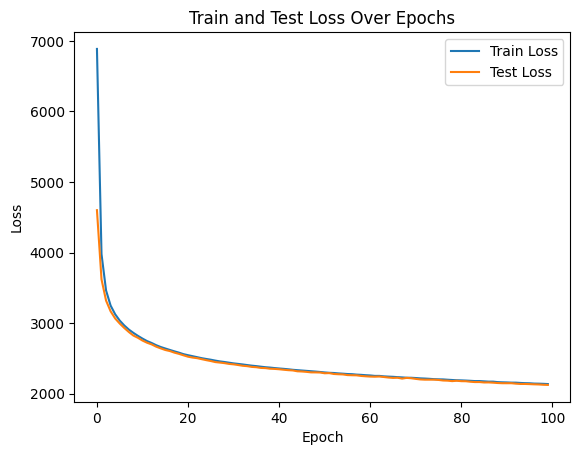

In [4]:

ae, optimizer, load_train, load_test, device = train_ae_setup(use_device=True, img_dim=784, hdn_dim=512, lat_dim=4, batch=100, lr=3e-4)

ae, train_losses, test_losses = train_ae(ae, optimizer, load_train, load_test, epochs=100, use_device=True, img_dim=784)

plot_train_ae(train_losses, test_losses)


## AE image reconstruction

Testing our trained AE on the test dataset

In [5]:
def ae_image_viz(ae, load_test, use_device=False, img_dim=784, num_images=5):
    '''
    Visualize original and reconstructed images side-by-side
    '''
    ae.eval()

    with torch.no_grad():
        x, _ = next(iter(load_test))  # Get a batch of test data
        if use_device: x = x.to(device).view(x.shape[0], img_dim)
        else: x = x.view(x.shape[0], img_dim)

        _, _, x_hat = ae(x)
        x = x.view(-1, 28, 28)
        x_hat = x_hat.view(-1, 28, 28)

        fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
        for i in range(num_images):
            # Original images
            axes[0, i].imshow(x[i].cpu().numpy(), cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title("Original")

            # Reconstructed images
            axes[1, i].imshow(x_hat[i].cpu().numpy(), cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title("Reconstructed")

        plt.tight_layout()
        plt.show()



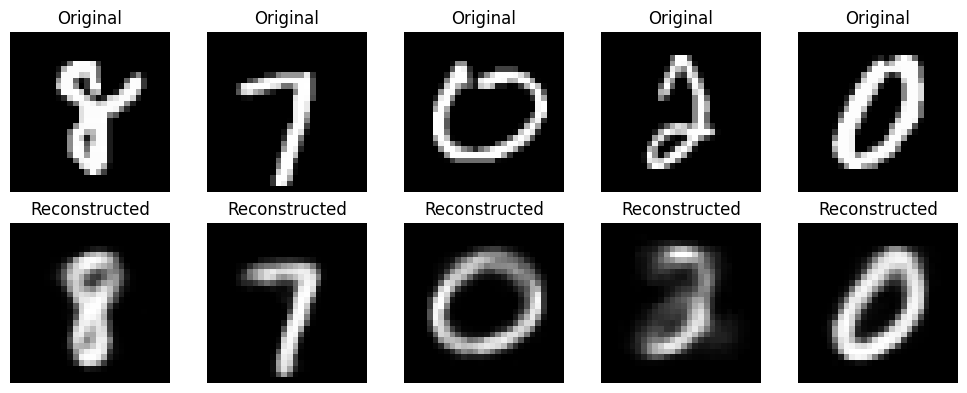

In [6]:
ae_image_viz(ae, load_test, use_device=True, img_dim=784, num_images=5)

## AE image generation

As there is no sampling from a distribution involved in a vanilla Autoencoder image generation is not possible. The image from the output will most likely not resemble any image from the training data.

torch.Size([784])


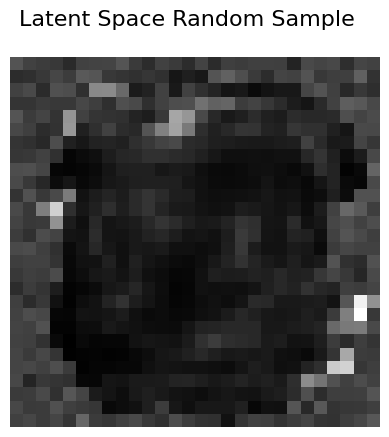

In [7]:
z = torch.randn(4)

z = z.to(device)
x_hat = torch.sigmoid(ae.decode(z))
print(x_hat.shape)
x_hat = x_hat.view(-1, 28, 28)
x_hat_img = x_hat.squeeze()

plt.imshow(x_hat_img.cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.suptitle("Latent Space Random Sample", fontsize=16)
plt.show()


In [13]:
def ae_image_viz_generated(ae, use_device=False, img_dim=784, grid_size=10, latent_dim=20):
    '''
    Visualize generated images in a grid matrix
    '''
    ae.eval()

    with torch.no_grad():
        # Generate random latent vectors from a normal distribution
        z = torch.randn(grid_size * grid_size, latent_dim)

        # Move the latent vectors to the appropriate device
        if use_device:
            z = z.to(device)

        # Decode the latent vectors to generate images
        x_gen = ae.decode(z)

        # Reshape the generated images to 28x28
        x_gen = x_gen.view(-1, 28, 28)

        # Create a grid for generated images
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
        fig.suptitle("Generated Images", fontsize=16)

        for i, ax in enumerate(axes.flat):
            ax.imshow(x_gen[i].cpu().numpy(), cmap='gray')
            ax.axis('off')

        plt.tight_layout()
        plt.subplots_adjust(top=0.9)  # Adjust the title position
        plt.show()

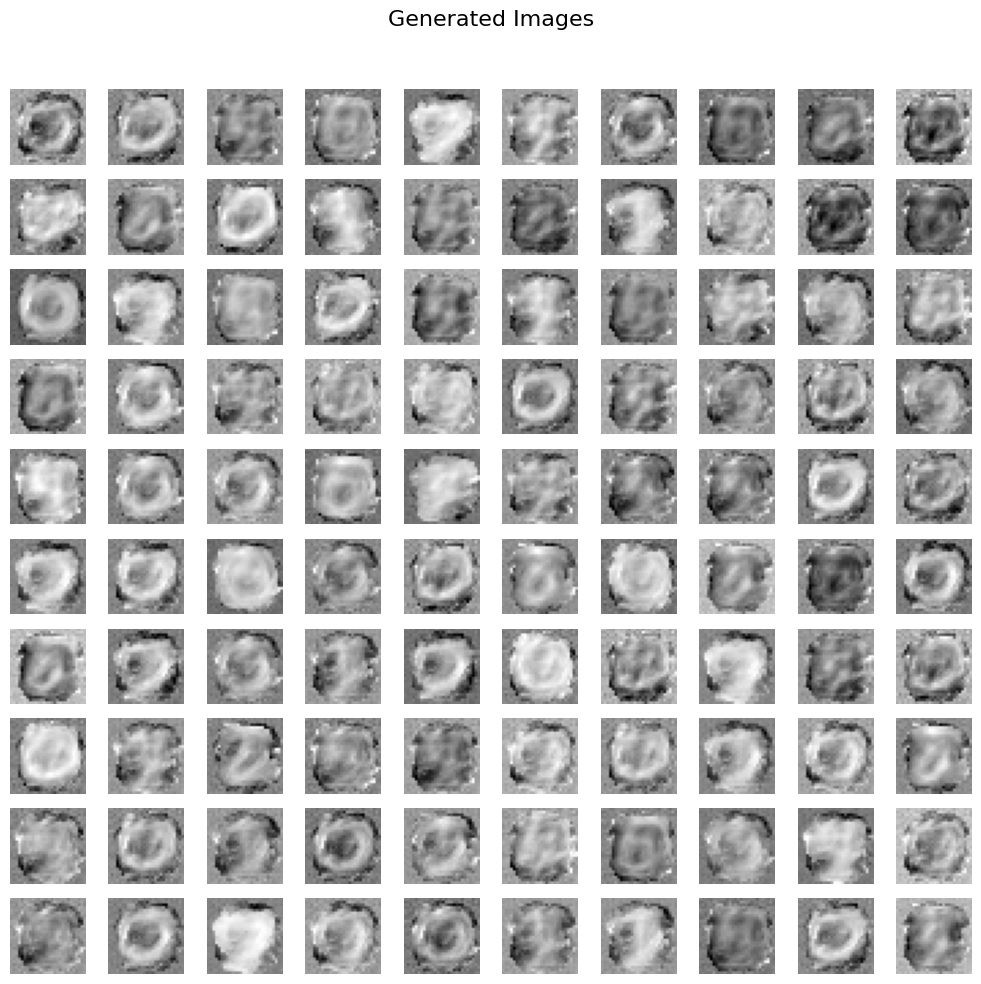

In [14]:
ae_image_viz_generated(ae, use_device=True, img_dim=784, grid_size=10, latent_dim=4)

# Variational Autoencoder


Image → Encoder → Hidden space → Latent Distribution → Reparametrization → Latent Space → Hidden space → Decoder → Reconstructed image  

Reconstructed image should be similar to the original one. $z$ is sampled from a Gaussian distribution.

Backpropagation through a stochastic element is not possible as the gradient cannot be computed.  
Solution to this is the reparametrization trick. We want to sample $z$ from a Normal distribution.

$g_{\phi}(\epsilon, x) = \mu_x + \epsilon \sigma_x$

$\phi = ${$\mu_x, \sigma_x$}

$\epsilon \sim 𝓝 (0, 1)$

$z = g_{\phi}(\epsilon, x)$

## Model architecture

In [15]:
class VAE(nn.Module):
    def __init__(self, img_dim, hdn_dim, lat_dim):
        super().__init__()

        # Encoder
        self.in_to_hdn = nn.Linear(img_dim, hdn_dim)
        self.hdn_to_mu = nn.Linear(hdn_dim, lat_dim)
        self.hdn_to_sigma = nn.Linear(hdn_dim, lat_dim)

        # Decoder
        self.lat_to_hdn = nn.Linear(lat_dim, hdn_dim)
        self.hdn_to_out = nn.Linear(hdn_dim, img_dim)

    def encode(self, x):
        '''
        Compress the input data into a lower dimensional representation
        '''
        hdn = F.relu(self.in_to_hdn(x))
        mu = self.hdn_to_mu(hdn)
        sigma = self.hdn_to_sigma(hdn)
        return mu, sigma

    def decode(self, lat):
        '''
        Expand the lower dimensional data to the same dimension as the input data
        '''
        hdn = F.relu(self.lat_to_hdn(lat))
        out = self.hdn_to_out(hdn)
        return torch.sigmoid(out)

    def reparameterize(self, mu, sigma):
        epsilon = torch.randn_like(sigma)
        lat = mu + epsilon * sigma
        return lat

    def forward(self, x):
        '''
        Forward pass called implicitly due to nn.module
        '''
        mu, sigma = self.encode(x)
        lat = self.reparameterize(mu, sigma)
        reconstruct = self.decode(lat)
        return lat, reconstruct, mu, sigma

## Training

In [16]:
def train_vae_setup(use_device=False, img_dim=784, hdn_dim=512, lat_dim=16, batch=50, lr=1e-3):
    '''
    Specifies device, loads datasets, sets optimizer, and initializes model
    '''
    if use_device:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(device)
        vae = VAE(img_dim, hdn_dim, lat_dim).to(device)
    else:
        vae = VAE(img_dim, hdn_dim, lat_dim)

    mnist_train = torchvision.datasets.MNIST(
        './data',
        train=True,
        download=True,
        transform=ToTensor(),
        target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
        )

    mnist_test = datasets.MNIST(
        './data',
        train=False,
        download=True,
        transform=ToTensor(),
        target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
        )

    load_train = DataLoader(dataset=mnist_train, batch_size=batch, shuffle=True)
    load_test = DataLoader(dataset=mnist_test, batch_size=batch, shuffle=True)

    # Think the VAE paper uses Adagrad but the author then released Adam a year after
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

    return vae, optimizer, load_train, load_test, device

In [17]:
def train_vae(vae, optimizer, load_train, load_test, use_device=False, epochs=50, img_dim=784):
    '''
    Training loop for VAE, includes KL divergence for the variational loss.
    '''
    train_losses = {}
    elbo_values = {}
    test_losses = {}
    test_elbos = {}
    recon_loss = nn.MSELoss(reduction='sum') # mean worked for vanilla ae but has to be sum here otherwise kl-divergence has to big of an impact

    for e in range(epochs):
        vae.train()
        train_loss = 0
        elbo_sum = 0
        finished_batches = 0

        # Training phase
        for i, (x, _) in enumerate(load_train):
            # Forward pass
            if use_device:
                x = x.to(device).view(x.shape[0], img_dim)
            else:
                x = x.view(x.shape[0], img_dim)

            lat, x_hat, mu, sigma = vae(x)

            # MSE for reconstruction loss (could use BCE-loss), and KL-div
            #sigma = sigma + 1e-6  # Prevent division by zero
            iter_loss = recon_loss(x_hat, x)
            kl_div = -0.5 * torch.sum(1 + torch.log(sigma**2) - mu**2 - sigma**2)

            # ELBO and total loss
            elbo = -(iter_loss + kl_div)
            total_loss = iter_loss + kl_div

            # Backpropagation
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            train_loss += total_loss.item()
            elbo_sum += elbo.item()
            finished_batches += 1

        epoch_loss = train_loss / finished_batches
        epoch_elbo = elbo_sum / finished_batches

        train_losses[e] = epoch_loss
        elbo_values[e] = epoch_elbo


        # Validation per epoch
        vae.eval()
        test_loss = 0
        test_elbo_sum = 0
        finished_test_batches = 0

        with torch.no_grad():
            for i, (x, _) in enumerate(load_test):
                if use_device:
                    x = x.to(device).view(x.shape[0], img_dim)
                else:
                    x = x.view(x.shape[0], img_dim)

                lat, x_hat, mu, sigma = vae(x)

                # MSE for reconstruction loss (could use BCE-loss), and KL-div
                #recon_loss = nn.BCELoss(reduction='mean')(x_hat, x)
                #sigma = sigma + 1e-6  # Prevent division by zero
                iter_loss = recon_loss(x_hat, x)
                kl_div = -0.5 * torch.sum(1 + torch.log(sigma**2) - mu**2 - sigma**2)

                # ELBO and total loss
                elbo = -(iter_loss + kl_div)
                total_loss = iter_loss + kl_div

                test_loss += total_loss.item()
                test_elbo_sum += elbo.item()
                finished_test_batches += 1

        epoch_test_loss = test_loss / finished_test_batches
        epoch_test_elbo = test_elbo_sum / finished_test_batches

        test_losses[e] = epoch_test_loss
        test_elbos[e] = epoch_test_elbo

        print(f"Epoch {e + 1}/{epochs} - Train Loss: {epoch_loss:.4f}, Train ELBO: {epoch_elbo:.4f}, "
              f"Test Loss: {epoch_test_loss:.4f}, Test ELBO: {epoch_test_elbo:.4f}")


    return vae, train_losses, elbo_values, test_losses, test_elbos


In [18]:
def plot_train_vae(train_losses, train_elbos, test_losses, test_elbos):
    '''
    Plot loss and ELBO for both training and test sets
    '''
    # Plot Loss for both train and test
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses.keys(), train_losses.values(), label='Train Loss', color='blue')
    plt.plot(test_losses.keys(), test_losses.values(), label='Test Loss', color='red', linestyle='--')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot ELBO for both train and test
    plt.figure(figsize=(8, 6))
    plt.plot(train_elbos.keys(), train_elbos.values(), label='Train ELBO', color='green')
    plt.plot(test_elbos.keys(), test_elbos.values(), label='Test ELBO', color='orange', linestyle='--')
    plt.title('ELBO Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('ELBO')
    plt.legend()
    plt.show()

cuda
Epoch 1/100 - Train Loss: 5590.1394, Train ELBO: -5590.1394, Test Loss: 4208.7083, Test ELBO: -4208.7083
Epoch 2/100 - Train Loss: 3914.2302, Train ELBO: -3914.2302, Test Loss: 3667.6923, Test ELBO: -3667.6923
Epoch 3/100 - Train Loss: 3572.1405, Train ELBO: -3572.1405, Test Loss: 3449.1655, Test ELBO: -3449.1655
Epoch 4/100 - Train Loss: 3414.5736, Train ELBO: -3414.5736, Test Loss: 3334.4139, Test ELBO: -3334.4139
Epoch 5/100 - Train Loss: 3321.8155, Train ELBO: -3321.8155, Test Loss: 3260.4072, Test ELBO: -3260.4072
Epoch 6/100 - Train Loss: 3257.4119, Train ELBO: -3257.4119, Test Loss: 3208.1648, Test ELBO: -3208.1648
Epoch 7/100 - Train Loss: 3210.0709, Train ELBO: -3210.0709, Test Loss: 3169.2964, Test ELBO: -3169.2964
Epoch 8/100 - Train Loss: 3180.1410, Train ELBO: -3180.1410, Test Loss: 3126.2297, Test ELBO: -3126.2297
Epoch 9/100 - Train Loss: 3149.9959, Train ELBO: -3149.9959, Test Loss: 3112.6169, Test ELBO: -3112.6169
Epoch 10/100 - Train Loss: 3123.5774, Train ELBO: 

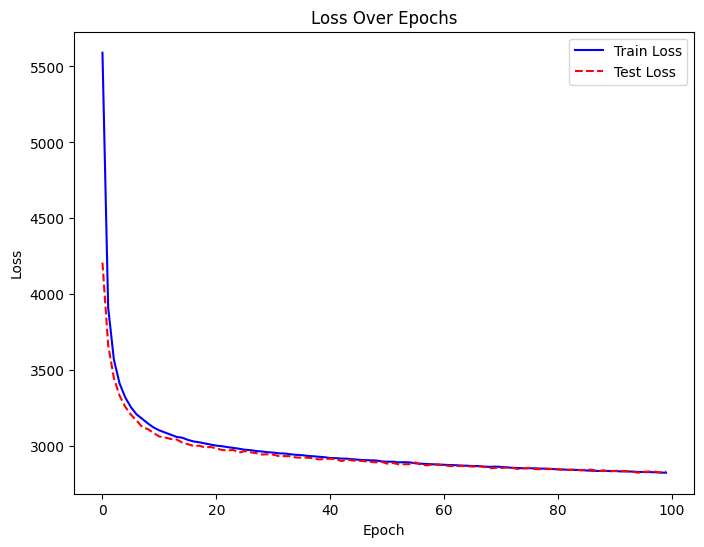

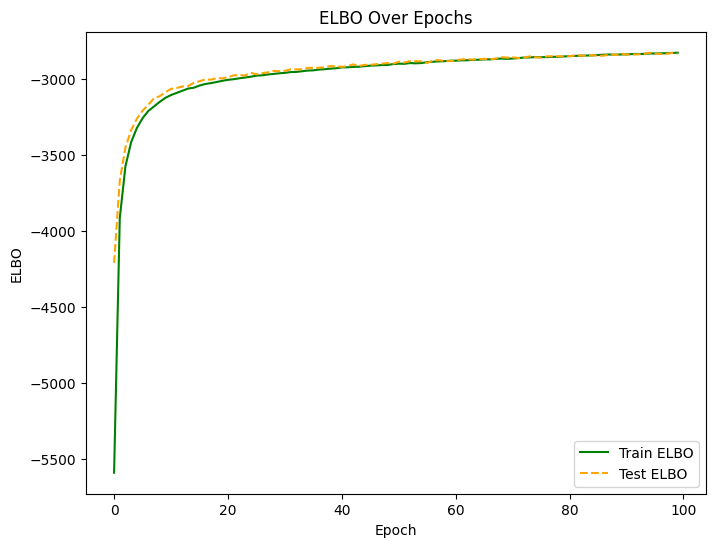

In [19]:
vae, optimizer, load_train, load_test, device = train_vae_setup(use_device=True, img_dim=784, hdn_dim=512, lat_dim=16, batch=100, lr=3e-4)
vae, losses, elbos, test_losses, test_elbos = train_vae(vae, optimizer, load_train, load_test, use_device=True, epochs=100, img_dim=784)

print("Training losses:", losses)
print("Training ELBOs:", elbos)
print("Test losses:", test_losses)
print("Test ELBOs:", test_elbos)

plot_train_vae(losses, elbos, test_losses, test_elbos)


## VAE image reconstruction

In [20]:
def vae_image_viz(vae, load_test, use_device=False, img_dim=784, num_images=5):
    '''
    Visualize original and reconstructed images side-by-side
    '''
    vae.eval()

    with torch.no_grad():
        x, _ = next(iter(load_test))  # Get a batch of test data
        if use_device: x = x.to(device).view(x.shape[0], img_dim)
        else: x = x.view(x.shape[0], img_dim)

        _, x_hat, _, _ = vae(x)
        x = x.view(-1, 28, 28)
        x_hat = x_hat.view(-1, 28, 28)

        fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
        for i in range(num_images):
            # Original images
            axes[0, i].imshow(x[i].cpu().numpy(), cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title("Original")

            # Reconstructed images
            axes[1, i].imshow(x_hat[i].cpu().numpy(), cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title("Reconstructed")

        plt.tight_layout()
        plt.show()

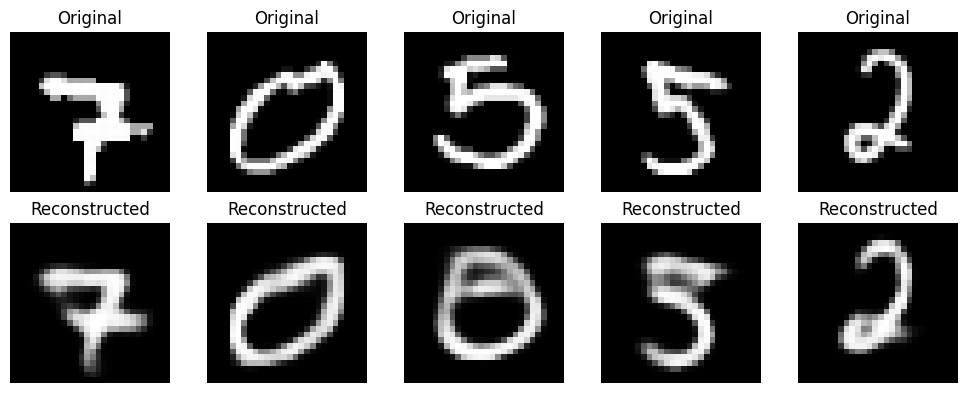

In [ ]:
vae_image_viz(vae, load_test, use_device=True, img_dim=784, num_images=5)

In [21]:
def vae_image_viz_matrix(vae, load_test, use_device=False, img_dim=784, grid_size=10):
    '''
    Visualize original and reconstructed images in two separate 10x10 matrices
    '''
    vae.eval()

    with torch.no_grad():
        # Get a batch of test data
        x, _ = next(iter(load_test))

        # Move the data to the appropriate device (GPU or CPU)
        if use_device:
            x = x.to(device).view(x.shape[0], img_dim)
        else:
            x = x.view(x.shape[0], img_dim)

        # Get reconstructed images from the VAE
        _, x_hat, _, _ = vae(x)

        # Reshape the images back to 28x28
        x = x.view(-1, 28, 28)
        x_hat = x_hat.view(-1, 28, 28)

        # Select the first grid_size * grid_size images
        num_images = grid_size * grid_size
        x = x[:num_images]
        x_hat = x_hat[:num_images]

        # Create a grid for original images
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
        fig.suptitle("Original Images", fontsize=16)

        for i, ax in enumerate(axes.flat):
            ax.imshow(x[i].cpu().numpy(), cmap='gray')
            ax.axis('off')

        plt.tight_layout()
        plt.subplots_adjust(top=0.92)  # Adjust the title position
        plt.show()

        # Create a grid for reconstructed images
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
        fig.suptitle("Reconstructed Images", fontsize=16)

        for i, ax in enumerate(axes.flat):
            ax.imshow(x_hat[i].cpu().numpy(), cmap='gray')
            ax.axis('off')

        plt.tight_layout()
        plt.subplots_adjust(top=0.92)  # Adjust the title position
        plt.show()

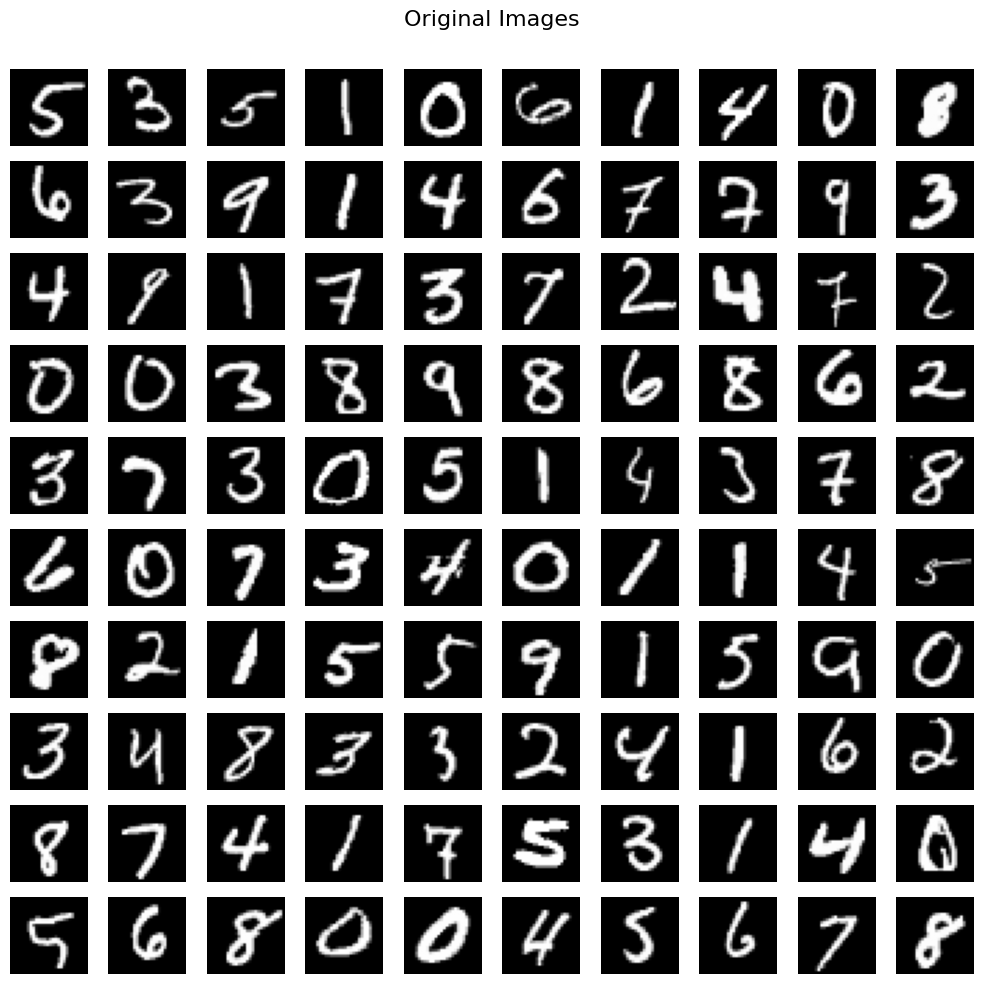

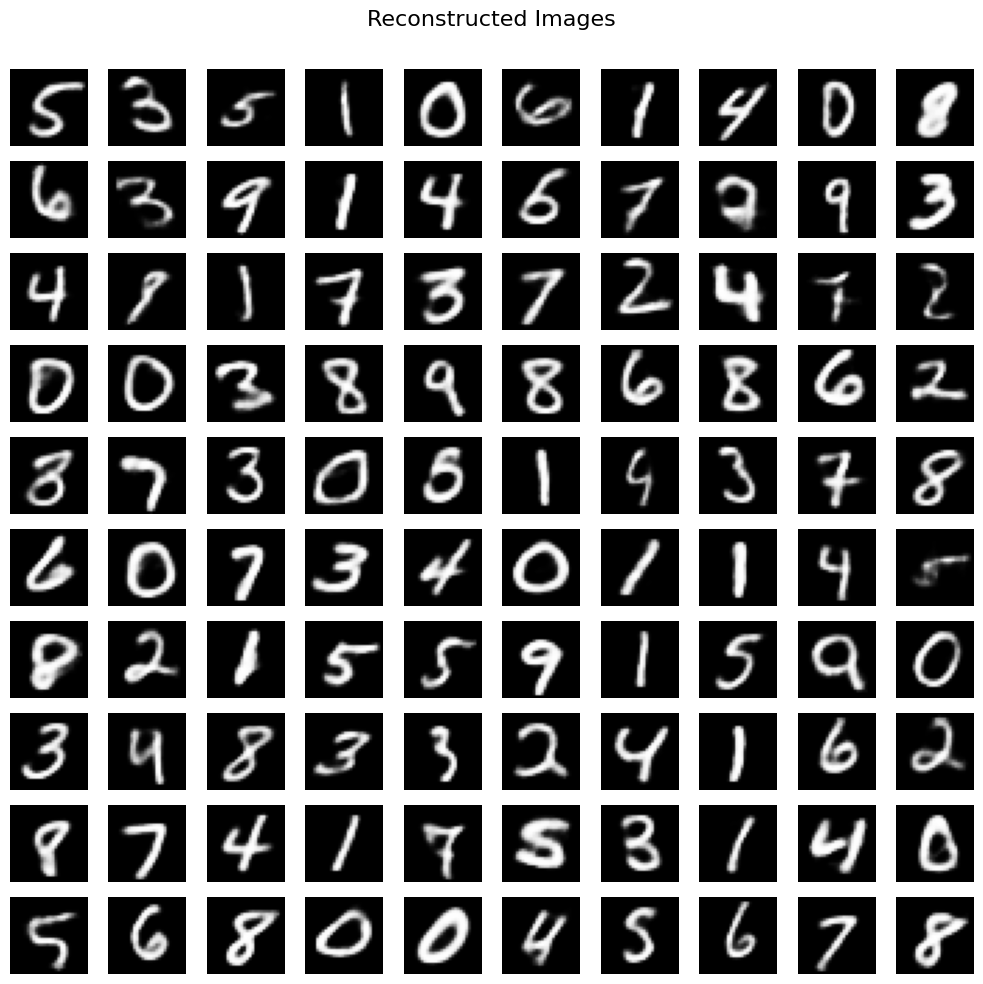

In [ ]:
vae_image_viz_matrix(vae, load_test, use_device=True, img_dim=784, grid_size=10)

## VAE image generation

In [22]:
def vae_image_viz_generated(vae, use_device=False, img_dim=784, grid_size=10, latent_dim=20):
    '''
    Visualize generated images in a grid matrix
    '''
    vae.eval()

    with torch.no_grad():
        # Generate random latent vectors from a normal distribution
        z = torch.randn(grid_size * grid_size, latent_dim)

        # Move the latent vectors to the appropriate device
        if use_device:
            z = z.to(device)

        # Decode the latent vectors to generate images
        x_gen = vae.decode(z)

        # Reshape the generated images to 28x28
        x_gen = x_gen.view(-1, 28, 28)

        # Create a grid for generated images
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
        fig.suptitle("Generated Images", fontsize=16)

        for i, ax in enumerate(axes.flat):
            ax.imshow(x_gen[i].cpu().numpy(), cmap='gray')
            ax.axis('off')

        plt.tight_layout()
        plt.subplots_adjust(top=0.9)  # Adjust the title position
        plt.show()


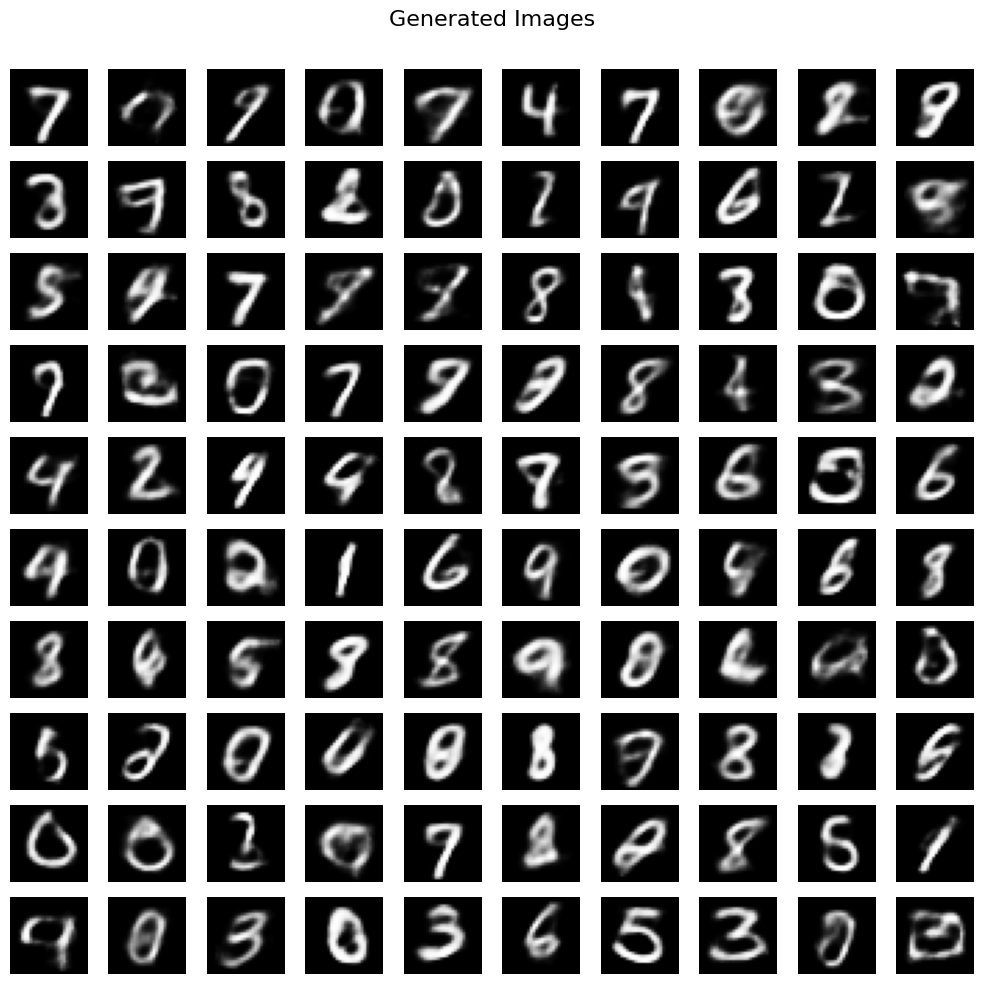

In [24]:

vae_image_viz_generated(vae, use_device=True, img_dim=784, grid_size=10, latent_dim=16)
